# Building a simple neural network using the nn module in PyTorch

This is a similar use case to the torch quick start at (https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

### Globals

In [1]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn

TORCH_DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)


def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

### Loading data

Shape of inputs (aka 'X') is torch.Size([64, 1, 28, 28])
Shape of targets (aka 'y') is torch.Size([64])


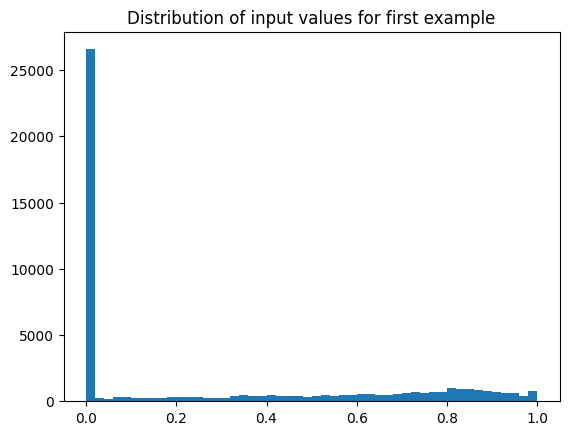

In [2]:
from torch.utils import data
from torchvision import datasets
from torchvision.transforms import ToTensor


def get_dataloader(batch_size: int, train: bool):
    mnist_dataset = datasets.FashionMNIST(
        root="data",
        train=train,
        download=True,
        transform=ToTensor(),
    )

    return data.DataLoader(mnist_dataset, batch_size=batch_size)


training_dataloader = get_dataloader(batch_size=64, train=True)
testing_dataloader = get_dataloader(batch_size=64, train=False)

for inputs, targets in training_dataloader:
    print(f"Shape of inputs (aka 'X') is {inputs.shape}")
    print(f"Shape of targets (aka 'y') is {targets.shape}")
    break

fig, axs = plt.subplots()
axs.hist(inputs.ravel(), bins=50)
axs.set_title("Distribution of input values for first example")
plt.show()

### Building the network

In [3]:
class SimpleNetwork(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_in, dim_hidden, bias=False),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden, bias=False),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_out, bias=False),
        )

    def forward(self, x):
        return self.stack(x)

In [4]:
# Testing / demonstrating the model
pic_height = 27
pic_width = 29
image_shape = (1, pic_height, pic_width)
dim_in = math.prod(image_shape)
dim_hidden = 24
dim_out = 10
sample_batch_size = 100

sample_model = SimpleNetwork(dim_in, dim_hidden, dim_out).to(TORCH_DEVICE)
print(sample_model)

sample_rand_gen = torch.Generator(device=TORCH_DEVICE).manual_seed(12345678)
sample_inputs = torch.normal(mean=0, std=1, size=(sample_batch_size, 1, pic_height, pic_width), generator=sample_rand_gen, device=TORCH_DEVICE)
result = sample_model(sample_inputs)
print(f"{sample_inputs.shape=}, {result.shape=}")
assert result.shape == (sample_batch_size, dim_out)

SimpleNetwork(
  (stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=783, out_features=24, bias=False)
    (2): ReLU()
    (3): Linear(in_features=24, out_features=24, bias=False)
    (4): ReLU()
    (5): Linear(in_features=24, out_features=10, bias=False)
  )
)
sample_inputs.shape=torch.Size([100, 1, 27, 29]), result.shape=torch.Size([100, 10])


### Training the network

In [5]:
# Note: from the docs for CrossEntropyLoss:
# 'The input is expected to contain the unnormalized logits for each class
# (which do not need to be positive or sum to 1, in general)'
# ie we don't need a separate nn.LogSoftmax layer here
loss_fn = nn.CrossEntropyLoss()

In [6]:
def test(dataloader, model, loss_fn):
    all_targets = []
    all_predictions = []
    all_losses = []
    # While weren't not using any layers that switch behavior between
    # training and evaluation, it's good practice to switch here.
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(TORCH_DEVICE)
            targets = targets.to(TORCH_DEVICE)
            predictions = model(inputs)
            loss = loss_fn(predictions, targets)
            all_predictions.append(predictions.argmax(dim=1))
            all_targets.append(targets)
            all_losses.append(loss)

    all_predictions = torch.cat(all_predictions)
    all_targets = torch.cat(all_targets)

    return all_targets, all_predictions, all_losses

In [7]:
pic_height = pic_width = 28
dim_hidden = 512
dim_out = 10

# Setting a lot of seeds to try and be reproducible
# Note: even with this, different pytorch versions and different backends
# will not / may not give the same results.
set_seed(12345678)

model = SimpleNetwork(pic_height * pic_width, dim_hidden, dim_out).to(TORCH_DEVICE)
with torch.no_grad():
    initial_params = [[p.detach().clone().cpu() for p in layer.parameters()] for layer in model.stack]

learning_rate = 1e-3 # 0.05  # 1e-3
epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_start = time.monotonic()
    total_length = len(training_dataloader.dataset)
    count = 0
    model.train()
    for batch, (inputs, targets) in enumerate(training_dataloader):
        inputs = inputs.to(TORCH_DEVICE)
        targets = targets.to(TORCH_DEVICE)
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)

        if batch % 100 == 0 or count >= total_length:
            print(f"loss: {loss.item():>7f}  [{count:>5d} / {total_length:>5d}]")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        count += len(inputs)
    
    epoch_end = time.monotonic()
    test_targets, test_preds, test_losses = test(testing_dataloader, model, loss_fn)
    correct = (test_preds.eq(test_targets).sum() / len(test_preds)).item()
    losses = torch.tensor(test_losses)
    print(f"Test error: accuracy = {100 * correct:>0.1f}%, average loss = {losses.mean().item():>8f}")
    print(f"Epoch elapsed time = {epoch_end - epoch_start:.1f} seconds")
    print("")

Epoch 1
-------------------------------
loss: 2.305007  [    0 / 60000]
loss: 2.290205  [ 6400 / 60000]
loss: 2.275063  [12800 / 60000]
loss: 2.269913  [19200 / 60000]
loss: 2.253097  [25600 / 60000]
loss: 2.222951  [32000 / 60000]
loss: 2.230523  [38400 / 60000]
loss: 2.194707  [44800 / 60000]
loss: 2.202223  [51200 / 60000]
loss: 2.178854  [57600 / 60000]
Test error: accuracy = 43.9%, average loss = 2.168086
Epoch elapsed time = 2.5 seconds

Epoch 2
-------------------------------
loss: 2.177582  [    0 / 60000]
loss: 2.165944  [ 6400 / 60000]
loss: 2.113138  [12800 / 60000]
loss: 2.135956  [19200 / 60000]
loss: 2.090388  [25600 / 60000]
loss: 2.023387  [32000 / 60000]
loss: 2.064053  [38400 / 60000]
loss: 1.976806  [44800 / 60000]
loss: 1.993648  [51200 / 60000]
loss: 1.944993  [57600 / 60000]
Test error: accuracy = 55.4%, average loss = 1.926499
Epoch elapsed time = 2.3 seconds

Epoch 3
-------------------------------
loss: 1.952780  [    0 / 60000]
loss: 1.924276  [ 6400 / 60000]


### Using the network

In [8]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

test_targets, test_preds, test_losses = test(testing_dataloader, model, loss_fn)

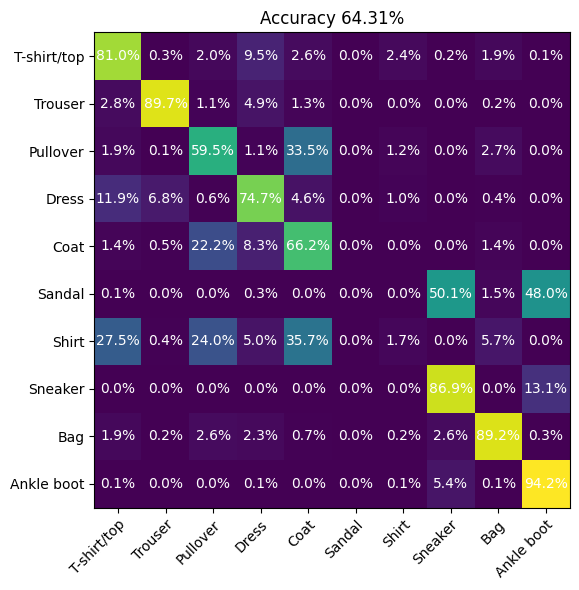

In [9]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_targets.detach().cpu(), test_preds.detach().cpu())
confusion = confusion / confusion.sum(axis=1)

accuracy = (test_preds.eq(test_targets).sum() / len(test_preds)).item()

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(confusion)
ax.set_xticks(torch.arange(len(classes)), labels=classes)
ax.set_yticks(torch.arange(len(classes)), labels=classes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, f"{confusion[i, j]:.1%}",
                       ha="center", va="center", color="w")

ax.set_title(f"Accuracy {accuracy:.2%}")
fig.tight_layout()

plt.show()

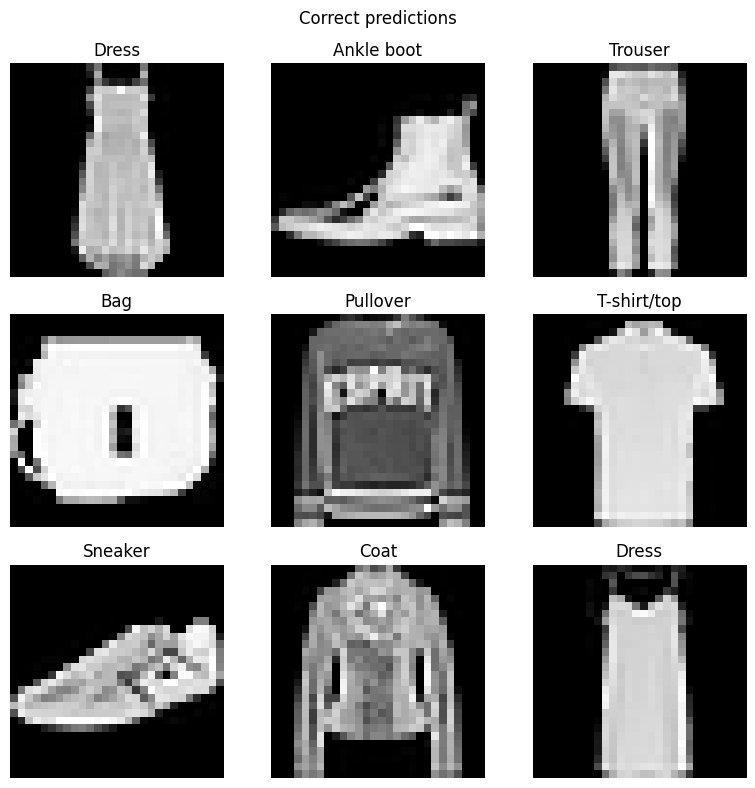

In [10]:
correct = torch.nonzero(test_targets == test_preds)

cols, rows = 3, 3
fig_gen = torch.Generator().manual_seed(12345678)
samples = correct[torch.randint(len(correct), size=(cols * rows,), generator=fig_gen)]
imgs_with_labels = [testing_dataloader.dataset[sample.item()] for sample in samples]

fig = plt.figure(figsize=(8, 8))
for i, (img, label) in enumerate(imgs_with_labels):
    fig.add_subplot(rows, cols, i + 1)
    plt.title(f"{classes[label]}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
fig.suptitle("Correct predictions")
fig.tight_layout()
plt.show()

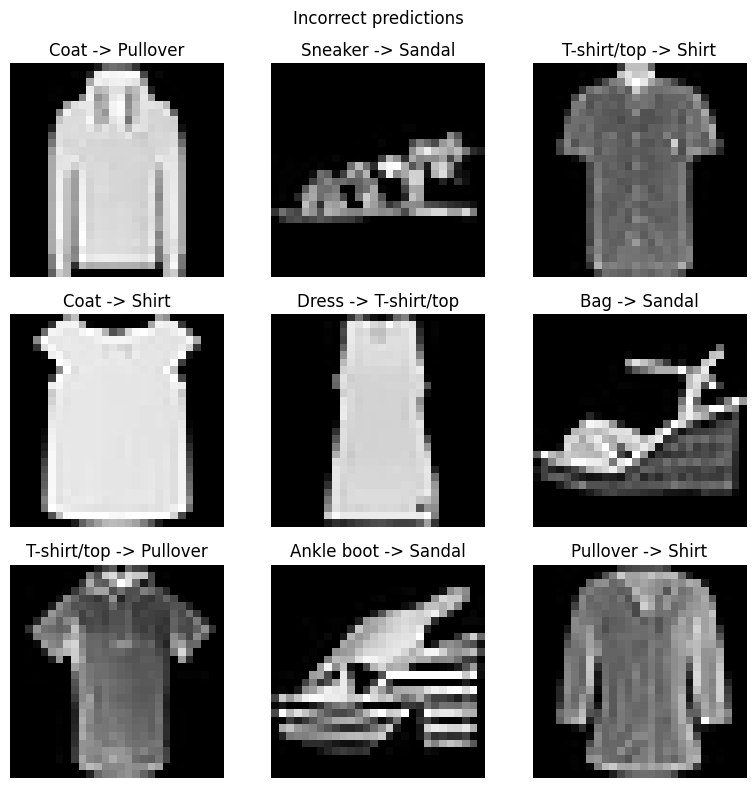

In [11]:
incorrect = torch.nonzero(test_targets != test_preds)

cols, rows = 3, 3
fig_gen = torch.Generator().manual_seed(12345678)
samples = incorrect[torch.randint(len(incorrect), size=(cols * rows,), generator=fig_gen)]
imgs_with_labels = [testing_dataloader.dataset[sample.item()] for sample in samples]

fig = plt.figure(figsize=(8, 8))
for i, (img, label) in enumerate(imgs_with_labels):
    predicted = classes[test_preds[samples[i]].item()]
    actual = classes[label]
    fig.add_subplot(rows, cols, i + 1)
    plt.title(f"{predicted} -> {actual}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

fig.suptitle("Incorrect predictions")
fig.tight_layout()
plt.show()